Notebook used for running QRL on QPU.



In [ ]:
# General imports
import numpy as np

# Qiskit Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal

# Qiskit imports
import qiskit as qk
import qiskit_aer

# Qiskit Machine Learning imports
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.optim import LBFGS, SGD, Adam, RMSprop

import rep_env

# OpenAI Gym import
from numpy import int32

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

import pandas as pd
import matplotlib.pyplot as plt


import helper as hlp

In [13]:
# Wandb Logging
# Keep it False for now.
wandb_logging = True

if wandb_logging:
    # Logging Package
    import wandb

# Random Seed for Reproducibility
rng = np.random.default_rng(seed=12345)

In [14]:
# Functions to make the PQC Circuit.
def encoding_circuit(inputs, num_qubits=4, *args):
    qc = qk.QuantumCircuit(num_qubits)

    # Encode data with a RX rotation
    for i in range(len(inputs)):
        qc.rx(inputs[i], i)

    return qc


def parametrized_circuit(num_qubits=4, reuploading=False, reps=2, insert_barriers=True, meas=False):
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)

    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr, cr)

    if not reuploading:

        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)

        # Encode classical input data
        qc.compose(encoding_circuit(inputs, num_qubits=num_qubits), inplace=True)
        if insert_barriers:
            qc.barrier()

        # Variational circuit
        qc.compose(TwoLocal(num_qubits, ['ry', 'rz'], 'cz', 'circular',
                            reps=reps, insert_barriers=insert_barriers,
                            skip_final_rotation_layer=True), inplace=True)
        if insert_barriers:
            qc.barrier()

        # Add final measurements
        if meas:
            qc.measure(qr, cr)

    elif reuploading:

        # Define a vector containing Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)

        # Define a vector containing variational parameters
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)

        # Iterate for a number of repetitions
        for rep in range(reps):

            # Encode classical input data
            qc.compose(encoding_circuit(inputs, num_qubits=num_qubits), inplace=True)
            if insert_barriers: qc.barrier()

            # Variational circuit (does the same as TwoLocal from Qiskit)
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2 * num_qubits * (rep)], qubit)
                qc.rz(θ[qubit + 2 * num_qubits * (rep) + num_qubits], qubit)
            if insert_barriers: qc.barrier()

            # Add entanglers (this code is for a circular entangler)
            qc.cz(qr[-1], qr[0])
            for qubit in range(num_qubits - 1):
                qc.cz(qr[qubit], qr[qubit + 1])
            if insert_barriers: qc.barrier()

        # Add final measurements
        if meas: qc.measure(qr, cr)

    return qc

In [15]:
# ### Create the PQC
# We can use the functions just defined to create the Parametrized Quantum Circuit:

# Select the number of qubits
num_qubits = 3
layers = 1
reuploading = True

# Generate the Parametrized Quantum Circuit (note the flags reuploading and reps)
qc = parametrized_circuit(num_qubits=num_qubits,
                          reuploading=reuploading,
                          reps=layers)

# Fetch the parameters from the circuit and divide them in Inputs (X) and Trainable Parameters (params)
# The first four parameters are for the inputs 
X = list(qc.parameters)[: num_qubits]

# The remaining ones are the trainable weights of the quantum neural network
params = list(qc.parameters)[num_qubits:]

qc.draw()

┌──────────┐ ░ ┌──────────┐┌──────────┐ ░           ░ 
qr_0: ┤ Rx(x[0]) ├─░─┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░──■──■─────░─
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │  │     ░ 
qr_1: ┤ Rx(x[1]) ├─░─┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░──┼──■──■──░─
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │     │  ░ 
qr_2: ┤ Rx(x[2]) ├─░─┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░──■─────■──░─
      └──────────┘ ░ └──────────┘└──────────┘ ░           ░

In [16]:
from braket.tracking import Tracker

from qiskit_braket_provider import AWSBraketProvider, BraketLocalBackend

# Use Braket SDK Cost Tracking to estimate the cost to run this example
t = Tracker().start()

provider = AWSBraketProvider()

In [17]:
provider.backends(statuses=["ONLINE"])

[BraketBackend[Aria 1],
 BraketBackend[Forte 1],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

In [18]:
# AWS Braket Device Selection
aria1 = provider.get_backend("Aria 1")
# aria1 = provider.get_backend("SV1")

In [19]:
aria1.description

'AWS Device: IonQ Aria 1.'

In [20]:
# Create a Quantum Neural Network object starting from the quantum circuit defined above
qnn = CircuitQNN(qc, input_params=X, weight_params=params,
                 quantum_instance=aria1)

# Connect to PyTorch
initial_weights = (2 * np.random.rand(qnn.num_weights) - 1)
quantum_nn = TorchConnector(qnn, initial_weights)

In [21]:
# PyTorch Layers for pre-processing and post-processing.
class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits=4):
        super().__init__()

        # Define weights for the layer
        weights = torch.Tensor(num_qubits)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, -1, 1)  # <--  Initialization strategy

    def forward(self, x):
        """Forward step, as explained above."""

        if not isinstance(x, Tensor):
            x = Tensor(x)

        x = self.weights * x
        x = torch.atan(x)

        return x


class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space=2):
        super().__init__()

        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 35, 40)  # <-- Initialization strategy (heuristic choice)

        self.mask_Z0 = torch.tensor([-1., 1., -1., 1., -1., 1., -1., 1.], requires_grad=False)
        self.mask_Z1 = torch.tensor([-1., -1., 1., 1., -1., -1., 1., 1.], requires_grad=False)
        self.mask_Z2 = torch.tensor([-1., -1., -1., -1., 1., 1., 1., 1.], requires_grad=False)
        self.mask_Z012 = torch.tensor([-1., 1., 1., -1., 1., -1., -1., 1.], requires_grad=False)

    def forward(self, x):
        """Forward step, as described above."""
        expval_Z0 = self.mask_Z0 * x
        expval_Z1 = self.mask_Z1 * x
        expval_Z2 = self.mask_Z2 * x
        expval_Z012 = self.mask_Z012 * x

        # Single sample
        if len(x.shape) == 1:
            expval_Z0 = torch.sum(expval_Z0)
            expval_Z1 = torch.sum(expval_Z1)
            expval_Z2 = torch.sum(expval_Z2)
            expval_Z012 = torch.sum(expval_Z012)
            out = torch.cat(
                (expval_Z0.unsqueeze(0), expval_Z1.unsqueeze(0), expval_Z2.unsqueeze(0), expval_Z012.unsqueeze(0)))

        # Batch of samples
        else:
            expval_Z0 = torch.sum(expval_Z0, dim=1, keepdim=True)
            expval_Z1 = torch.sum(expval_Z1, dim=1, keepdim=True)
            expval_Z2 = torch.sum(expval_Z2, dim=1, keepdim=True)
            expval_Z012 = torch.sum(expval_Z012, dim=1, keepdim=True)
            out = torch.cat((expval_Z0, expval_Z1, expval_Z2, expval_Z012), 1)

        return self.weights * ((out + 1.) / 2.)


In [22]:

# Classical trainable preprocessing
encoding = encoding_layer(num_qubits=3)

# Classical trainable postprocessing
exp_val = exp_val_layer(action_space=4)

# Stack the classical and quantum layers together 
model = torch.nn.Sequential(encoding,
                            quantum_nn,
                            exp_val)
model.state_dict()


OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343])),
             ('1.weight',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880])),
             ('1._weights',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880])),
             ('2.weights', tensor([39.7965, 36.9522, 38.0045, 36.2829]))])

In [23]:
model.load_state_dict(torch.load("models\Model_qnn_1000_3_1_True_4_0.99_0.01_1000_0.9_100_t_12_30_d_05_03_2024.pth"))

<All keys matched successfully>

In [24]:
model.state_dict()

OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343])),
             ('1.weight',
              tensor([-0.2871,  3.1351,  2.2076,  0.0608, -0.6908, -0.3639])),
             ('1._weights',
              tensor([-0.2871,  3.1351,  2.2076,  0.0608, -0.6908, -0.3639])),
             ('2.weights', tensor([42.3756, 42.8710, 40.1728, 34.3534]))])

In [25]:
# Defining the environment.
Starting_Capital = 1000
env = rep_env.rep_env(ProductID=4, StoreID=14, Capital=Starting_Capital)

In [26]:
input_shape = [3]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

# Training Functions.
from collections import deque

replay_memory = deque(maxlen=2000)


def epsilon_greedy_policy(state, epsilon=0):
    """Manages the transition from the *exploration* to *exploitation* phase"""
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        with torch.no_grad():
            Q_values = model(Tensor(state)).numpy()
            # Q_values = model(state).detach().numpy()
        # return np.argmax(Q_values[0])
        return np.argmax(Q_values)


def sample_experiences(batch_size):
    """Sample some experiences from the replay memory"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]

    states = np.array([experience[0] for experience in batch])
    actions = np.array([experience[1] for experience in batch])
    rewards = np.array([experience[2] for experience in batch])
    next_states = np.array([experience[3] for experience in batch])
    dones = np.array([experience[4] for experience in batch])

    return states, actions, rewards, next_states, dones


def play_one_step(env, state, epsilon):
    """Perform one action in the environment and register the state of the system"""
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, _, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info


def sequential_training_step(batch_size):
    """
    Actual training routine. Implements the Deep Q-Learning algorithm.
    """

    # Sample past experiences 
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences

    # Evaluates Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(a=next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)

    # Accumulate Loss sequentially (if batching data, gradients of the parameters are vanishing)
    loss = 0.
    for j, state in enumerate(states):
        single_Q_value = model(Tensor(state))
        Q_value = single_Q_value[actions[j]]
        loss += (target_Q_values[j] - Q_value) ** 2
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [27]:
# Hyperparameters.
batch_size = 4
discount_rate = 0.99
learning_rate = 1e-2
optimizer = Adam(model.parameters(), lr=learning_rate)

rewards = []
best_score = 0
episodes = 100
max_steps = env.n_weeks + 1
exploration_ratio = 0.9
exploration_episode = round(exploration_ratio * episodes)
exploration_experience = 40

hyperparameters = {
    "Starting Capital": Starting_Capital,
    "num_qubits": num_qubits,
    "layers": layers,
    "reuploading": reuploading,
    "batch_size": batch_size,
    "discount_rate": discount_rate,
    "learning_rate": learning_rate,
    "episodes": episodes,
    "exploration_ratio": exploration_ratio,
    "exploration_experience": exploration_experience
}


In [28]:
if wandb_logging:
    wandb.init(project='tcs-bloq-qrl', config=hyperparameters, tags='QNN',notes='f{aria1.description}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: londhenikhil15. Use `wandb login --relogin` to force relogin


In [29]:

# print(f'The weekly demand is: {env.weekly_demand}')

# # Main Training Loop

# from tqdm import tqdm

# for episode in tqdm(range(episodes), colour='green', miniters=1):
#     # wandb.watch(model)

#     # Run environment simulation
#     obs = env.reset()[0]
#     ep_reward = 0

#     for step in range(max_steps):
#         # Manages the transition from exploration to exploitation
#         epsilon = max(1 - episode / exploration_episode, 0.01)
#         obs, reward, done, info = play_one_step(env, obs, epsilon)
#         ep_reward += reward
#         if done:
#             break
#     rewards.append(ep_reward)

#     # Saving best agent
#     if ep_reward >= best_score:
#         best_score = ep_reward

#     if wandb_logging:
#         wandb.log({'Train Reward': ep_reward})

#     if episode % 100 == 0:
#         print(f'Episode: {episode},Reward: {ep_reward}')

#     # Start training only after some exploration experiences  
#     if episode >= exploration_experience:
#         sequential_training_step(batch_size)

# print(f'Best score in Training: {best_score}')

# if wandb_logging:
#     wandb.log({'Best Training score': best_score})

# torch.save(model.state_dict(),
#            "models/" + hlp.generate_filename(hyperparameters, file_type="Model", model_type='qnn') + '.pth')


# def plot_rewards(rewards, save):
#     plt.figure(figsize=(17, 5))
#     plt.plot(rewards, lw=1, label='Training Rewards')

#     plt.title("Training QNN Rewards", fontsize=14)

#     plt.xlabel("Episode", fontsize=14)
#     plt.ylabel("Reward", fontsize=14)
#     plt.grid()
#     plt.legend()

#     plot_fname = hlp.generate_filename(hyperparameters=hyperparameters, file_type='Training_Rewards', model_type='qnn')
#     plot_path = 'plots/' + plot_fname + '.png'
#     if save:
#         plt.savefig(plot_path)

#     if wandb_logging:
#         wandb.log({'Training Rewards Plot': wandb.Image(plot_path)})
#     # plt.show()


# # Plotting the training rewards
# plot_rewards(rewards, save=True)



In [33]:
env.weekly_demand

array([2, 0, 3, 1, 0, 3, 2, 2, 3, 1, 3, 1, 2, 2, 0, 0, 0, 2, 2, 3, 2, 0,
       3, 3, 2, 2])

Initial State:
2.0 1000.0 1.0

Demand Capital On_Hand Profit Replenishment Predicted Sale Actual Sale


d:\Anaconda\envs\awsqcs\lib\site-packages\qiskit_braket_provider\providers\adapter.py:438: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(
d:\Anaconda\envs\awsqcs\lib\site-packages\qiskit_braket_provider\providers\adapter.py:475: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


0.0 1006.6 1.0 6.6 1 1 1
3.0 953.8 2.0 -52.8 1 0 0
1.0 1070.4 0.0 116.6 1 3 3
0.0 1077.0 0.0 6.6 1 1 1
3.0 1024.2 1.0 -52.8 1 0 0
2.0 1085.8 0.0 61.6 1 3 2
2.0 1092.4 0.0 6.6 1 1 1
3.0 1099.0 0.0 6.6 1 1 1
1.0 1105.6 0.0 6.6 1 1 1
3.0 1112.2 0.0 6.6 1 1 1
1.0 1118.8 0.0 6.6 1 2 1
2.0 1125.4 0.0 6.6 1 1 1
2.0 1132.0 0.0 6.6 1 2 1
0.0 1138.6 0.0 6.6 1 1 1
0.0 1085.8 1.0 -52.8 1 0 0
0.0 1033.0 2.0 -52.8 1 0 0
2.0 980.2 3.0 -52.8 1 0 0
2.0 993.4 3.0 13.2 2 2 2
3.0 1006.6 3.0 13.2 2 2 2
2.0 1123.2 1.0 116.6 1 3 3
0.0 1184.8 0.0 61.6 1 2 2
3.0 1132.0 1.0 -52.8 1 0 0
3.0 1193.6 0.0 61.6 1 3 2
2.0 1200.2 0.0 6.6 1 3 1
2.0 1206.8 0.0 6.6 1 2 1
2.0 1206.8 0.0 0 1
Episode Finished after 26 weeks
Total Reward: 206.79999999999998

Average Test Reward: 206.79999999999998


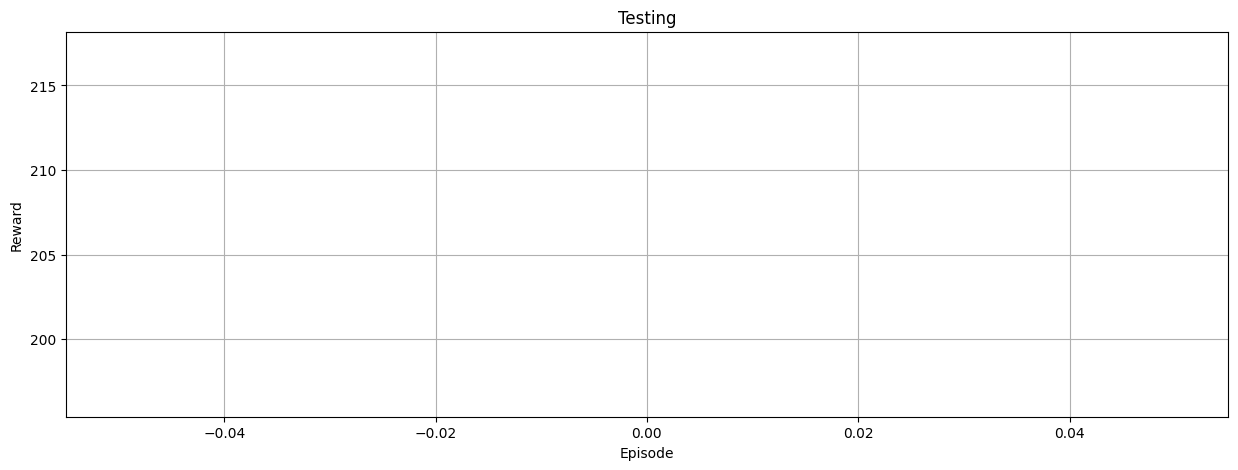

In [30]:
# Testing our model.
def test(test_evals=25, save=True):
    eval_rewards = []
    for _ in range(test_evals):
        rewards = 0
        state = torch.Tensor(env.reset()[0])
        print(f'Initial State:\n{state[2]} {state[0]} {state[1]}')

        print(f'\nDemand Capital On_Hand Profit Replenishment Predicted Sale Actual Sale')
        for step in range(env.n_weeks+1):
            action = epsilon_greedy_policy(state)
            next_state, reward, done, _, info = env.step(action)
            rewards += reward
            if not done:
                print(f'{state[2]} {round(state[0], 2)} {state[1]} {round(reward, 2)} {action} {info["Sampled Sale"]} {info["Sale"]}')
                state = next_state
            else:
                print(f'{state[2]} {round(state[0], 2)} {state[1]} {round(reward, 2)} {action}\n{info["msg"]}')
                print(f'Total Reward: {rewards}\n')
                state = next_state

        eval_rewards.append(rewards)
        if wandb_logging:
            wandb.log({'Test Reward': rewards})
    print(f'Average Test Reward: {np.mean(eval_rewards)}')

    plt.figure(figsize=(15, 5))
    plt.plot(range(test_evals), eval_rewards)
    plt.grid()

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Testing')

    # plt.text(1, round(average_eval_reward) - 10, f"Average Reward: {round(average_eval_reward,2)}", fontsize=12)
    plot_fname = hlp.generate_filename(hyperparameters, file_type='Testing Rewards', model_type='qnn')
    plot_path = 'plots/' + plot_fname + '.png'
    if save:
        plt.savefig(plot_path)
    # plt.show()

    if wandb_logging:
        wandb.log({'Average Test Reward': np.mean(eval_rewards)})
        wandb.log({'Testing Rewards Plot': wandb.Image(plot_path)})


# Testing our model
test(test_evals=1,save=True)



In [31]:
if wandb_logging:
    wandb.finish()

Average Test Reward,▁
Test Reward,▁
Average Test Reward,206.8
Test Reward,206.8


In [32]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing "
    "unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated "
    "charges do not factor in any discounts or credits, and you may experience additional charges "
    "based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD"
)

Quantum Task Summary
{'arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1': {'shots': 26624, 'tasks': {'COMPLETED': 26}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 806.520 USD


In [ ]:
2.0 1000.0 1.0 1 1 1
0.0 1006.6 1.0 6.6 1 0 0
3.0 953.8 2.0 -52.8 1 3 3
1.0 1070.4 0.0 116.1 1 16 
0.0 1077.0 0.0 6.6 1 0 0
3.0 1024.2 1.0 -52.8 1 3 2 
2.0 1085.8 0.0 61.6 1 1 1 
2.0 1092.4 0.0 6.6 1 1 1
3.0 1099.0 0.0 6.6 1 1 1
1.0 1105.6 0.0 6.6 1 1 1
3.0 1112.2 0.0 6.6 1 2 1
1.0 1118.8 0.0 6.6 1 1 1
2.0 1125.4 0.0 6.6 1 2 1
2.0 1132.0 0.0 6.6 1 1 1
0.0 1138.6 0.0 6.6 1 0 0
0.0 1085.8 1.0 -52.8 1 0 0
0.0 1033.0 2.0 -52.8 1 0 0 
2.0 980.2 3.0 -52.8 2 2 2 
2.0 993.4 3.0 13.2 2 2 2
3.0 1006.6 3.0 13.2 1 3 3
2.0 1123.2 1.0 116.6 1 2 2 
0.0 1184.8 0.0 61.6 1 0 0
3.0 1132.0 1.0 -52.8 1 3 2 
2.0 1200.2 0.0 6.6 1 2 1
3.0 1193.6 0.0 61.6 1 3 1 
2.0 1206.8 0.0 0 1
2.0 1206.8 0.0 6.6 


Episode Finished after 26 weeks
Total Reward: 206.79999999999998

Average Test Reward: 206.79999999999998

In [48]:
Capital =[
1000.0,
1006.6,
953.8,
1070.4,
1077.0,
1024.2,
1085.8,
1092.4,
1099.0,
1105.6,
1112.2,
1118.8,
1125.4,
1132.0,
1138.6,
1085.8,
1033.0,
980.2,
993.4,
1006.6,
1123.2,
1184.8,
1132.0,
1193.6,
1200.2,
1206.8]

On_hand = [1.0,
1.0,
2.0,
0.0,
0.0,
1.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
1.0,
2.0,
3.0,
3.0,
3.0,
1.0,
0.0,
1.0,
0.0,
0.0,
0.0]

In [34]:
profit = [
6.6,
-52.8,
116.6,
6.6,
-52.8,
61.6,
6.6,
6.6,
6.6,
6.6,
6.6,
6.6,
6.6,
6.6,
-52.8,
-52.8,
-52.8,
13.2,
13.2,
116.6,
61.6,
-52.8,
61.6,
6.6,
6.6]

In [35]:
Replenishment = [
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
2,
2,
1,
1,
1,
1,
1,
1]

In [37]:
Predicted_Sale = [
1,
0,
3,
1,
0,
3,
1,
1,
1,
1,
2,
1,
2,
1,
0,
0,
0,
2,
2,
3,
2,
0,
3,
3,
2]

Actual_Sale = [
1,
0,
3,
1,
0,
2,
1,
1,
1,
1,
1,
1,
1,
1,
0,
0,
0,
2,
2,
3,
2,
0,
2,
1,
1]

In [60]:
env.weekly_demand

array([2, 0, 3, 1, 0, 3, 2, 2, 3, 1, 3, 1, 2, 2, 0, 0, 0, 2, 2, 3, 2, 0,
       3, 3, 2, 2])

In [61]:
Demand = [2, 0, 3, 1, 0, 3, 2, 2, 3, 1, 3, 1, 2, 2, 0, 0, 0, 2, 2, 3, 2, 0,
       3, 3, 2, 2]

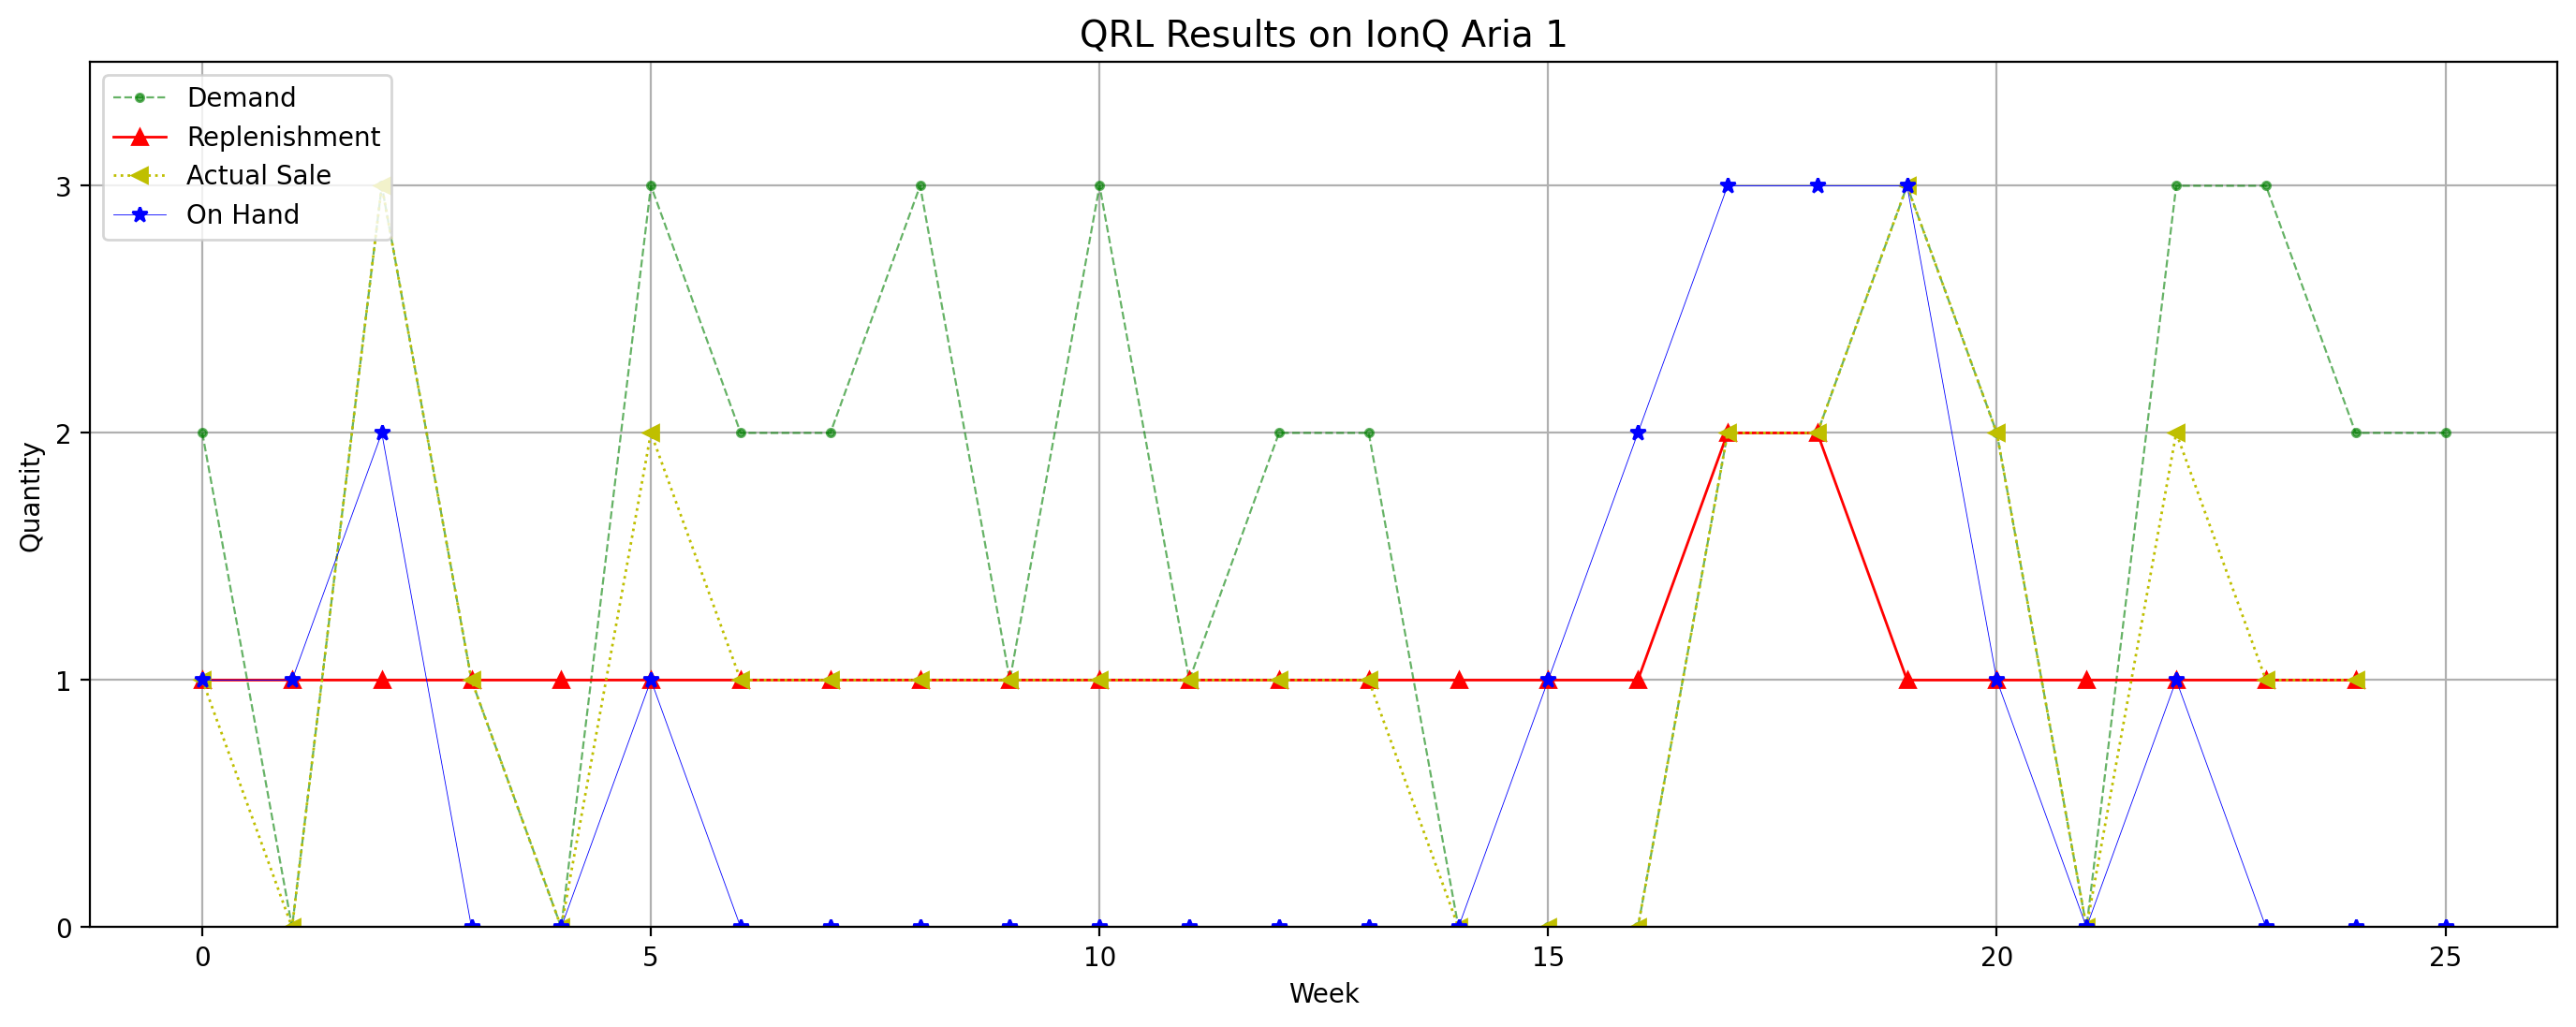

In [100]:
plt.figure(figsize=(17, 6),dpi=200)

plt.plot(Demand,c='g',lw=0.8,marker='.',label='Demand',alpha=0.6,ls='--')
plt.plot(Replenishment,lw=1,marker='^',c='r',label='Replenishment')
plt.plot(Actual_Sale,lw=1,marker='<',c='y',label='Actual Sale',ls=':')
# plt.plot(Predicted_Sale,lw=0.3,marker='*',c='y',label='Predicted Sale',alpha=0.)
plt.plot(On_hand,lw=0.3,marker='*',c='b',label='On Hand')

plt.ylabel('Quantity')
plt.xlabel('Week')

plt.ylim(0, 3.5 )

plt.yticks(np.arange(0, 4, 1))

plt.title('QRL Results on IonQ Aria 1',fontsize=14)

plt.grid()
plt.legend(loc='upper left')
plt.show()


Initial State:

Demand Capital On_Hand Profit Replenishment Predicted Sale Actual Sale



























Episode Finished after 26 weeks
Total Reward: 206.79999999999998

Average Test Reward: 206.79999999999998
